In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from geopandas import GeoDataFrame
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point

sns.set_style('darkgrid')

In [3]:
sales_gdf = pd.read_csv('data/sales_gdf.csv')
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
neighborhood_gdf = gpd.read_file('../data/Boundaries - Neighborhoods.geojson')

In [5]:
final_df = pd.read_csv('data/full_data.csv')
final_df["geo_12"] = final_df["GEO_ID"].map(lambda x: str(x)[-12:])
final_df.info()
final_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218374 entries, 0 to 218373
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   GEO_ID                    218353 non-null  object 
 1   Year                      218374 non-null  int64  
 2   pin                       218374 non-null  int64  
 3   sale_price                218374 non-null  float64
 4   age                       218374 non-null  int64  
 5   addr                      218371 non-null  object 
 6   hd_sf                     218374 non-null  float64
 7   n_units                   218374 non-null  float64
 8   bldg_sf                   132602 non-null  float64
 9   geometry                  218374 non-null  object 
 10  pri_neigh                 218374 non-null  object 
 11  sec_neigh                 218374 non-null  object 
 12  side                      218374 non-null  object 
 13  actual_sf                 218374 non-null  f

GEO_ID  Year             pin  sale_price  age  \
0  1500000US170318392002  2015  17273100931118     53000.0   44   
1  1500000US170313514001  2018  17343220150000    410000.0  130   
2  1500000US170318420001  2019  17341030641004    250000.0   11   

                  addr     hd_sf  n_units  bldg_sf  \
0  2921 S MICHIGAN AVE  365398.0    679.0      NaN   
1    3819 S WABASH AVE    3850.0      1.0   5050.0   
2        223 E 31ST ST    2738.0      3.0      NaN   

                                      geometry  ... Percent Black  \
0  POINT (-87.62257654590501 41.8402291575061)  ...      0.699771   
1  POINT (-87.62436774377279 41.8249549567756)  ...      0.917211   
2  POINT (-87.62080085952471 41.8381539098695)  ...           NaN   

  Percent HH with Children Percent Housing Vacant  Number of Public Schools  \
0                 0.265432               0.111835                       1.0   
1                 0.433090               0.062945                       1.0   
2                      NaN                    NaN                       NaN   

   crime_count  crimes_per_capita  station_id            station_name  \
0        209.0           0.159664     30382.0  Cermak-McCormick Place   
1        296.0           0.161220     30214.0    35th-Bronzeville-IIT   
2          NaN                NaN     30214.0    35th-Bronzeville-IIT   

   distance_miles        geo_12  
0        0.213983  170318392002  
1        0.183507  170313514001  
2        0.303191  170318420001  

[3 rows x 33 columns]

In [6]:
final_df[final_df['pri_neigh'] == 'Loop'][['pri_neigh', 'sale_price', 'addr', 'actual_sf']].sort_values(by='actual_sf')

pri_neigh  sale_price                 addr     actual_sf
178735      Loop     24000.0   235 W VAN BUREN ST     17.332037
180119      Loop     26000.0   235 W VAN BUREN ST     17.332037
180368      Loop    235000.0   235 W VAN BUREN ST     17.332037
179494      Loop    295000.0   235 W VAN BUREN ST     17.332037
180036      Loop    318500.0   235 W VAN BUREN ST     17.332037
...          ...         ...                  ...           ...
178855      Loop   1200000.0  1142 S MICHIGAN AVE   1068.750000
177823      Loop   1278500.0  1142 S MICHIGAN AVE   1068.750000
180439      Loop    215000.0    533 S PLYMOUTH CT   1921.000000
180830      Loop   1925000.0        192 N PARK DR  18187.222222
180611      Loop   1875000.0    225 N COLUMBUS DR  18187.222222

[3657 rows x 4 columns]

In [7]:
final_df['pricer_per_sqft'] = final_df['sale_price'] / final_df['actual_sf']
#final_df['pricer_per_unit'] = final_df['sale_price'] / final_df['n_units']
final_df_avgsale = pd.DataFrame(final_df.groupby('pri_neigh')['pricer_per_sqft'].mean().sort_values(ascending=False)).reset_index()
final_df_avgsale = final_df_avgsale.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')
final_df_avgsale[final_df_avgsale['side'] == 'Central']

pri_neigh  pricer_per_sqft     side
0    Streeterville              inf  Central
1  Rush & Division      3952.285508  Central
2             Loop      3817.829633  Central
3      River North      3790.253389  Central
4       Gold Coast      2999.647596  Central
5     Printers Row      1788.759813  Central
8  Near South Side      1314.880008  Central

# Data Visualization

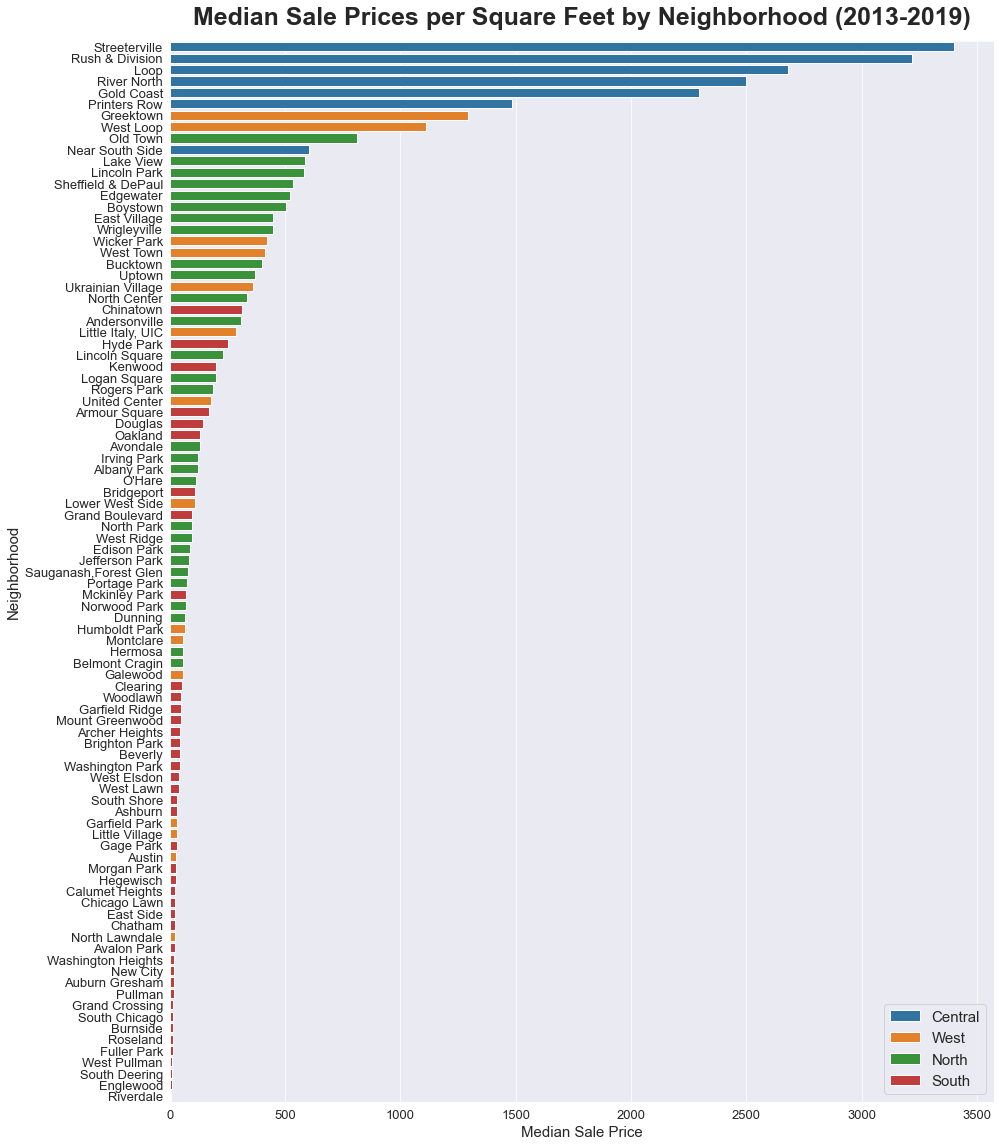

In [8]:
final_df['pricer_per_unit'] = final_df['sale_price'] / (final_df['hd_sf'] / final_df['n_units'])

final_df_avgsale = pd.DataFrame(final_df.groupby('pri_neigh')['pricer_per_unit'].median().sort_values(ascending=False)).reset_index()
final_df_avgsale = final_df_avgsale.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')

fig, ax = plt.subplots(figsize=(14,16))

sns.barplot(final_df_avgsale.pricer_per_unit, final_df_avgsale.pri_neigh, hue=final_df_avgsale.side, dodge=False)
ax.set_title('Median Sale Prices per Square Feet by Neighborhood (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Median Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/saleprice_per_sqft_by_nbh.png')
plt.show()

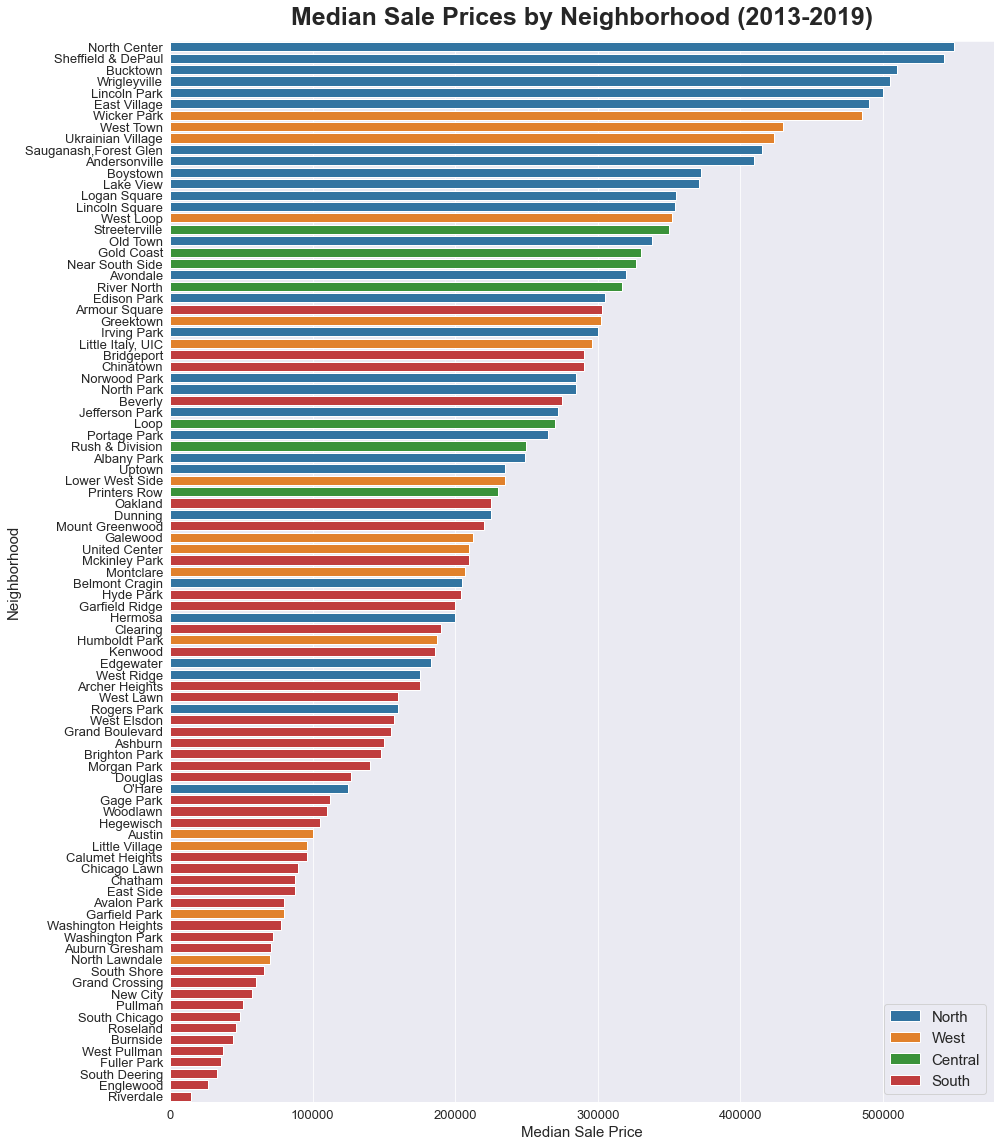

In [9]:
final_df_avgsale = pd.DataFrame(final_df.groupby('pri_neigh')['sale_price'].median().sort_values(ascending=False)).reset_index()
final_df_avgsale = final_df_avgsale.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')

fig, ax = plt.subplots(figsize=(14,16))

sns.barplot(final_df_avgsale.sale_price, final_df_avgsale.pri_neigh, hue=final_df_avgsale.side, dodge=False)
ax.set_title('Median Sale Prices by Neighborhood (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Median Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/median_saleprice_by_nbh.png')
plt.show()

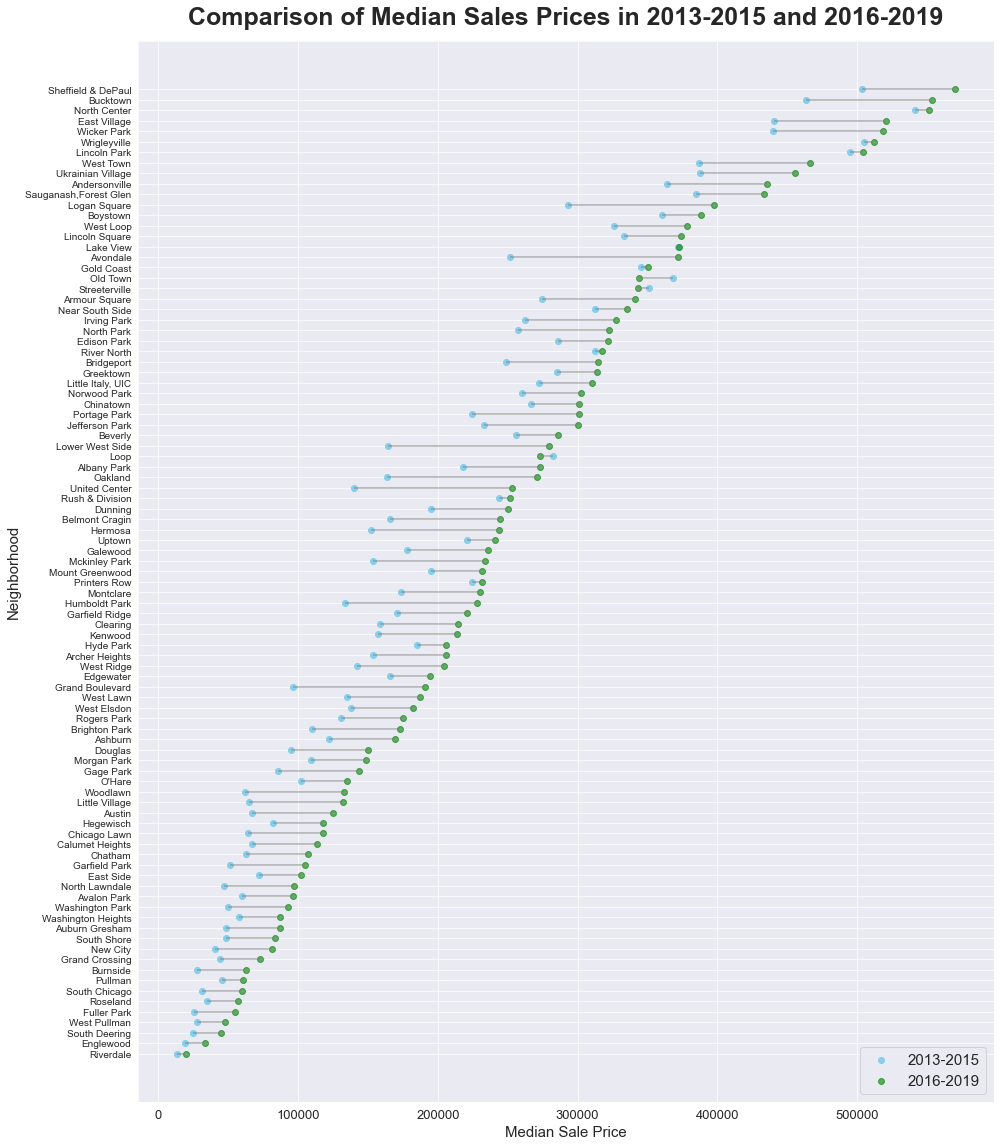

In [10]:
sales_compare = final_df.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
sales_compare['2013-2015'] = sales_compare[[2013, 2014, 2015]].mean(axis=1)
sales_compare['2016-2019'] = sales_compare[[2016, 2017, 2018, 2019]].mean(axis=1)
sales_compare = sales_compare[['2013-2015', '2016-2019']]
sales_compare = sales_compare.sort_values(by='2016-2019', ascending=True)


my_range=range(1,len(sales_compare.index)+1)
 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
fig, ax = plt.subplots(figsize=(14,16))

plt.hlines(y=my_range, xmin=sales_compare['2013-2015'], xmax=sales_compare['2016-2019'], color='grey', alpha=0.6)
plt.scatter(sales_compare['2013-2015'], my_range, color='skyblue', alpha=1, label='2013-2015')
plt.scatter(sales_compare['2016-2019'], my_range, color='green', alpha=0.6 , label='2016-2019')
plt.legend()
 
# Add title and axis names
ax.set_title('Comparison of Median Sales Prices in 2013-2015 and 2016-2019', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Median Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(my_range, sales_compare.index)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/median_saleprice_avg.png')
plt.show()

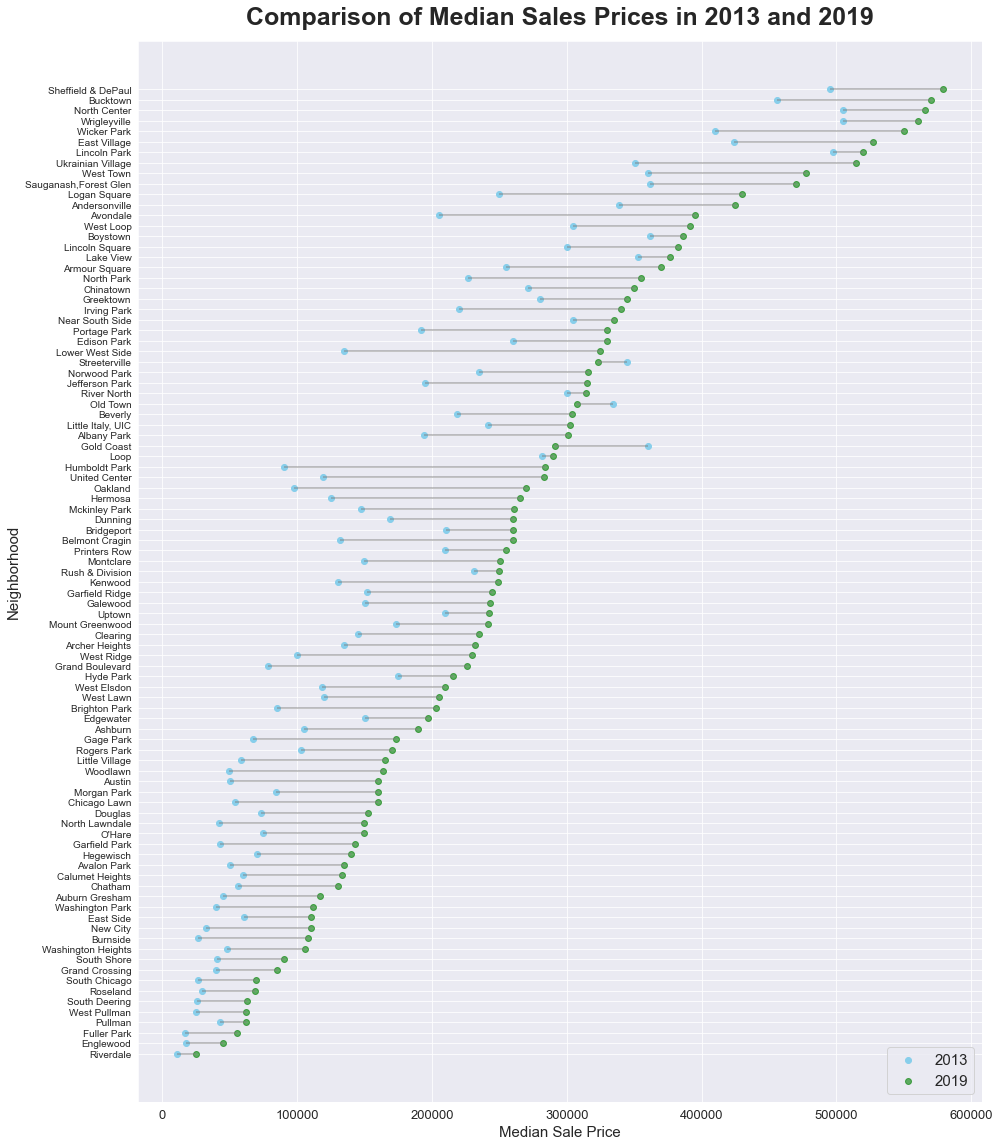

In [11]:
sales_compare_2 = final_df[(final_df['Year'] == 2013) | (final_df['Year'] == 2019)]
sales_compare_2 = sales_compare_2.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
sales_compare_2 = sales_compare_2.sort_values(by=2019, ascending=True)
sales_compare_2['diff'] = sales_compare_2[2019] - sales_compare_2[2013]


my_range=range(1,len(sales_compare_2.index)+1)
 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
fig, ax = plt.subplots(figsize=(14,16))

plt.hlines(y=my_range, xmin=sales_compare_2[2013], xmax=sales_compare_2[2019], color='grey', alpha=0.6)
plt.scatter(sales_compare_2[2013], my_range, color='skyblue', alpha=1, label='2013')
plt.scatter(sales_compare_2[2019], my_range, color='green', alpha=0.6 , label='2019')
plt.legend()
 
# Add title and axis names
ax.set_title('Comparison of Median Sales Prices in 2013 and 2019', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Median Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(my_range, sales_compare_2.index)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/median_saleprice.png')
plt.show()

      side      2013      2014      2015      2016      2017      2018
0  Central  3.466284  3.434414  3.441419  3.319768  2.864886  2.858917
1    North  3.889184  4.290038  4.528302  4.528302  4.440913  4.227642
2    South  1.751501  2.087119  2.743069  2.777127  3.061474  3.190351
3     West  3.604115  4.224709  4.939682  4.823778  4.996813  4.964020


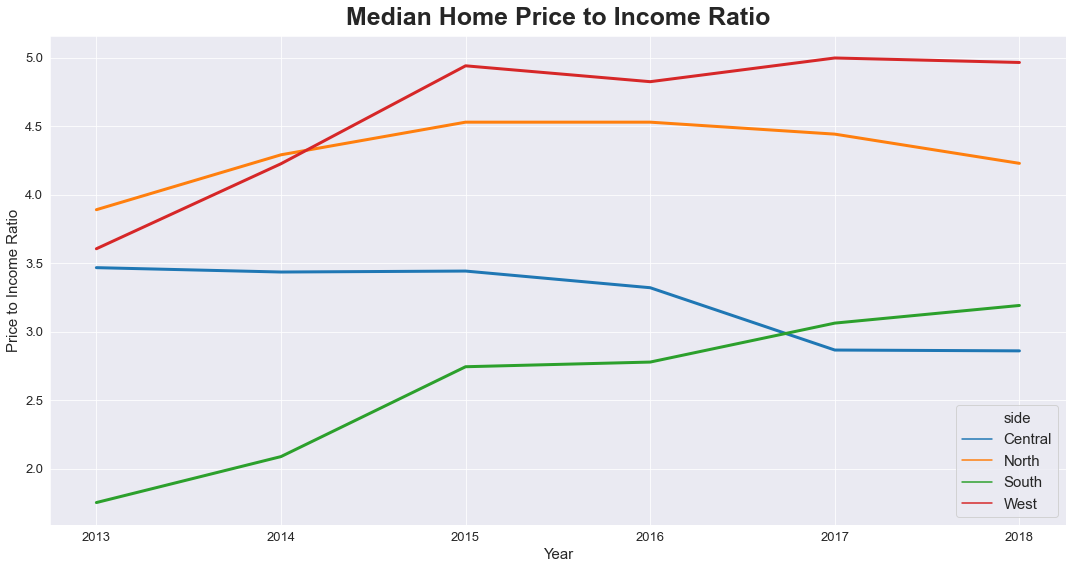

In [12]:
median_income_by_year = final_df.groupby(['side', 'Year'])['Median HH Income'].median().unstack()
median_price_by_year = final_df.groupby(['side', 'Year'])['sale_price'].median().unstack()
median_inc_to_price = pd.DataFrame()
for year in range(2013, 2019):
    median_inc_to_price[year] = median_price_by_year[year] / median_income_by_year[year]
median_inc_to_price = median_inc_to_price.reset_index()
print(median_inc_to_price.head())

median_inc_to_price = median_inc_to_price.melt(id_vars=["side"], var_name="year", value_name="price_to_income_ratio")

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(x="year", y="price_to_income_ratio", hue='side', data=median_inc_to_price, lw=3)
ax.set_title('Median Home Price to Income Ratio', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Price to Income Ratio', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/side_price_to_income_ratio.png')
plt.show()

        pri_neigh      2013      2014      2015      2016      2017      2018
63        Oakland  2.066203  2.300667  6.392447  4.417966  8.068127  9.681972
28    Fuller Park  0.834356  1.534884  1.017821  1.505665  1.614661  3.456749
21        Douglas  1.356222  2.812280  3.159225  3.600510  2.819977  4.189535
31  Garfield Park  1.484146  1.671034  2.579560  2.885574  3.448540  4.560394
57       New City  0.997755  1.347826  1.629265  2.002470  2.174163  2.903740


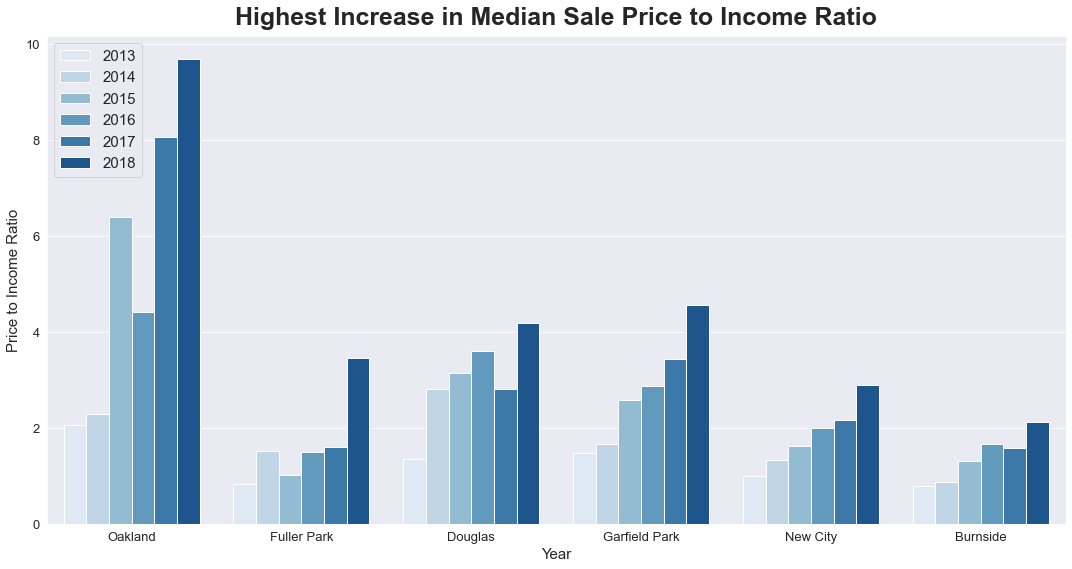

In [13]:
median_income_by_year = final_df.groupby(['pri_neigh', 'Year'])['Median HH Income'].median().unstack()
median_price_by_year = final_df.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
median_inc_to_price = pd.DataFrame()
for year in range(2013, 2019):
    median_inc_to_price[year] = median_price_by_year[year] / median_income_by_year[year]
median_inc_to_price = median_inc_to_price.reset_index()#.sort_values(by=2018, ascending=False)
median_inc_to_price['biggest_diff'] = (median_inc_to_price[2018] - median_inc_to_price[2013]) / median_inc_to_price[2013]
median_inc_to_price = median_inc_to_price.sort_values(by='biggest_diff', ascending=False)
median_inc_to_price = median_inc_to_price[['pri_neigh', 2013, 2014, 2015, 2016, 2017, 2018]]
print(median_inc_to_price.head())

median_inc_to_price = median_inc_to_price[:6].melt(id_vars=["pri_neigh"], var_name="year", value_name="price_to_income_ratio")

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15,8))
#sns.palplot(sns.color_palette("Blues"))

sns.barplot(x="pri_neigh", y="price_to_income_ratio", hue="year", data=median_inc_to_price, palette="Blues")
#sns.barplot(x="year", y="price_to_income_ratio", hue="pri_neigh", data=median_inc_to_price)
#sns.lineplot(x="year", y="price_to_income_ratio", hue='pri_neigh', data=median_inc_to_price, lw=3)
ax.set_title('Highest Increase in Median Sale Price to Income Ratio', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Price to Income Ratio', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', fontsize=15)

fig.tight_layout()
plt.savefig('figures/neighborhood_price_to_income_ratio.png')
plt.show()

       pri_neigh   side  sale_price  Percent White  count
44     Lake View  North    371000.0       0.877754  12894
45  Lincoln Park  North    500000.0       0.879563   6530
81        Uptown  North    235000.0       0.713781   5340
65  Portage Park  North    265255.5       0.700915   5146
25     Edgewater  North    183000.0       0.708833   5025


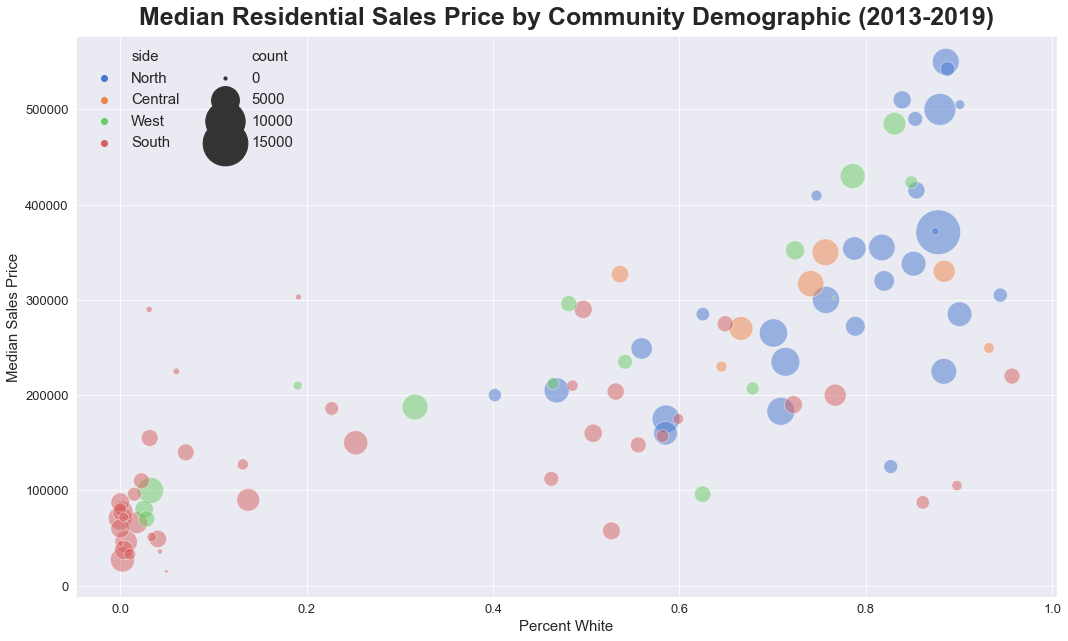

In [14]:
sale_pop = final_df.groupby(['pri_neigh', 'side']).agg({'sale_price':'median', 'Percent White':'median', 'pin':'count'})
sale_pop = sale_pop.reset_index().rename(columns={"pin": "count"})
sale_pop = sale_pop.sort_values(by='count', ascending=False)
print(sale_pop.head())

#sns.set(style="white")
fig, ax = plt.subplots(figsize=(15,9))

sns.scatterplot(x="Percent White", y="sale_price", hue="side", size="count",
                sizes=(10, 2000), alpha=.5, palette="muted", data=sale_pop)
ax.set_title('Median Residential Sales Price by Community Demographic (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Percent White', fontsize=15)
ax.set_ylabel('Median Sales Price', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', fontsize=15, ncol=2, frameon=False)

fig.tight_layout()
plt.savefig('figures/demographic_scatter.png')
plt.show()

In [15]:
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df, row="Year", hue="Year", aspect=5.5, height=2.2, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, "sale_price", clip_on=False, shade=True, alpha=1, lw=10.5, bw=2)
# g.map(sns.kdeplot, "sale_price", clip_on=False, color="w", lw=2, bw=.2)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0.9, .1, label, fontweight="bold", color=color, fontsize=30,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, "sale_price")

# # Set the subplots to overlap
# g.fig.subplots_adjust(hspace=-.8)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[])
# g.despine(bottom=True, left=True)

# plt.savefig('figures/overlap_density.png')
# plt.show()

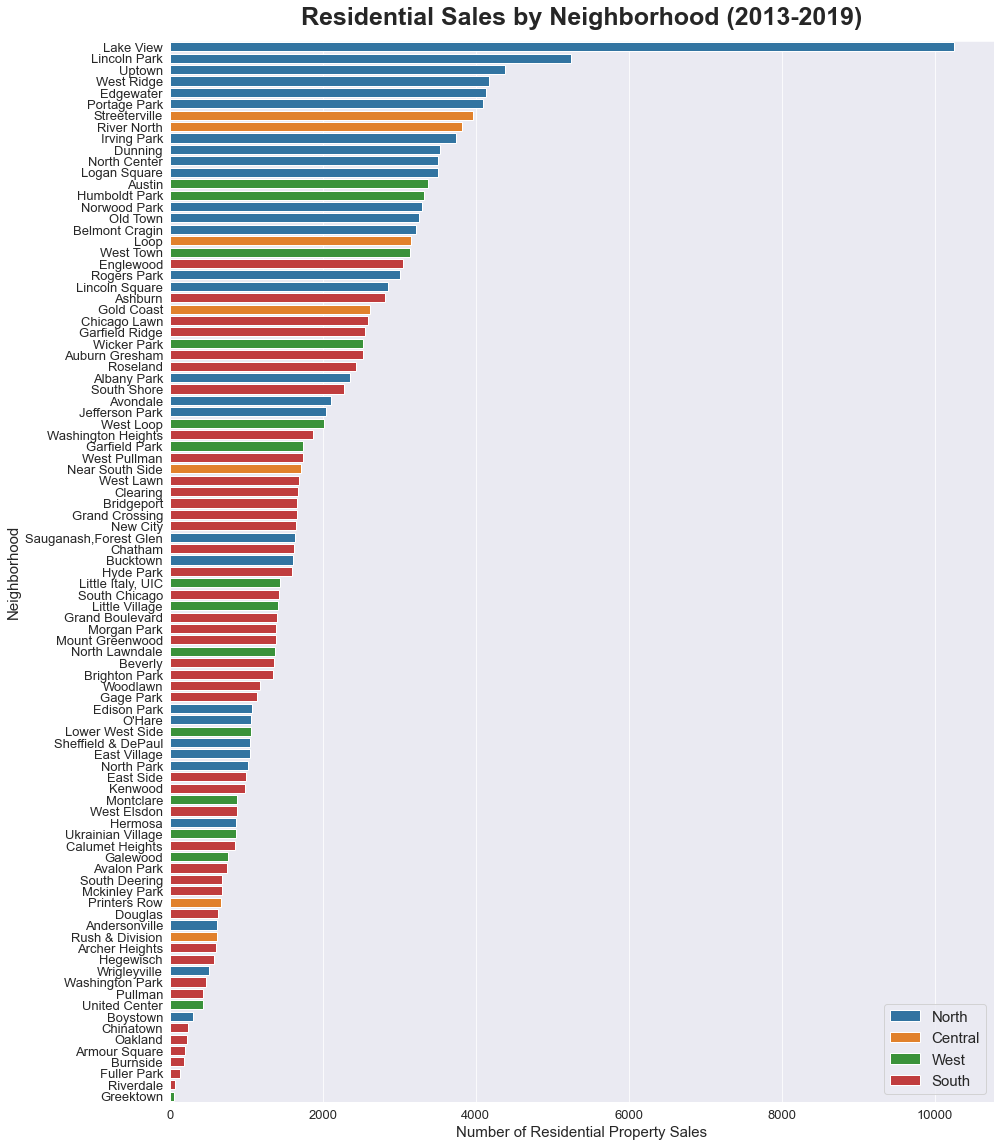

In [16]:
sales_gdf_count = pd.DataFrame(sales_gdf.groupby('pri_neigh')['pin'].nunique().sort_values(ascending=False)).reset_index()
sales_gdf_count = sales_gdf_count.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(14,16))

sns.barplot(sales_gdf_count.pin, sales_gdf_count.pri_neigh, hue=sales_gdf_count.side, dodge=False)
ax.set_title('Residential Sales by Neighborhood (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Number of Residential Property Sales', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

fig.tight_layout()
plt.savefig('figures/num_sales.png')
plt.show()

In [17]:
sales_compare = final_df.groupby(['geo_12', 'Year'])['sale_price'].median().unstack()
sales_compare['2013-2015'] = sales_compare[[2013, 2014, 2015]].mean(axis=1)
sales_compare['2016-2019'] = sales_compare[[2016, 2017, 2018, 2019]].mean(axis=1)
sales_compare['sales_price_diff'] = (sales_compare['2016-2019'] - sales_compare['2013-2015'])  / sales_compare['2013-2015']
sales_compare = sales_compare.reset_index()
sales_compare = sales_compare.sort_values(by='sales_price_diff')[:-6]
sales_compare

Year        geo_12      2013          2014       2015      2016          2017  \
359   170310810005       NaN  6.586000e+06        NaN  645000.0           NaN   
353   170310804002       NaN           NaN  1150000.0       NaN  565000.00000   
1080  170313510003  442000.0           NaN   465000.0  115000.0   85000.00000   
1626  170316708002   87500.0  9.200000e+04   115000.0   19000.0   30100.00000   
292   170310701021  188000.0  1.000500e+06    50000.0  137194.0  175000.00000   
...            ...       ...           ...        ...       ...           ...   
968   170312606001   16000.0  2.055000e+04    33000.0  135000.0   54900.00000   
1185  170314313011   24250.0  2.000000e+04    23300.0   45400.0  113500.00000   
1239  170314603023   34121.5  2.650000e+04    20450.0  133000.0  135000.00000   
1003  170312912001   36750.0  3.200000e+04    21000.0   87500.0  160500.00000   
1030  170313012002       NaN  2.652124e+04        NaN  112000.0   83360.24735   

Year           2018      2019     2013-2015      2016-2019  sales_price_diff  
359   545000.000000       NaN  6.586000e+06  595000.000000         -0.909657  
353    25000.000000   25000.0  1.150000e+06  205000.000000         -0.821739  
1080  128900.000000  145000.0  4.535000e+05  118475.000000         -0.738754  
1626   45000.000000   37500.0  9.816667e+04   32900.000000         -0.664856  
292   192000.000000  181700.0  4.128333e+05  171473.500000         -0.584642  
...             ...       ...           ...            ...               ...  
968    88000.000000  105500.0  2.318333e+04   95850.000000          3.134436  
1185   65700.000000  152900.0  2.251667e+04   94375.000000          3.191340  
1239  147314.850717   42500.0  2.702383e+04  114453.712679          3.235288  
1003  101750.000000  220000.0  2.991667e+04  142437.500000          3.761142  
1030  159000.000000  155000.0  2.652124e+04  127340.061837          3.801436  

[2144 rows x 11 columns]

         geo_12  sales_price_diff
0  170310810005         -0.909657
1  170310804002         -0.821739
2  170313510003         -0.738754
3  170316708002         -0.664856
4  170310701021         -0.584642


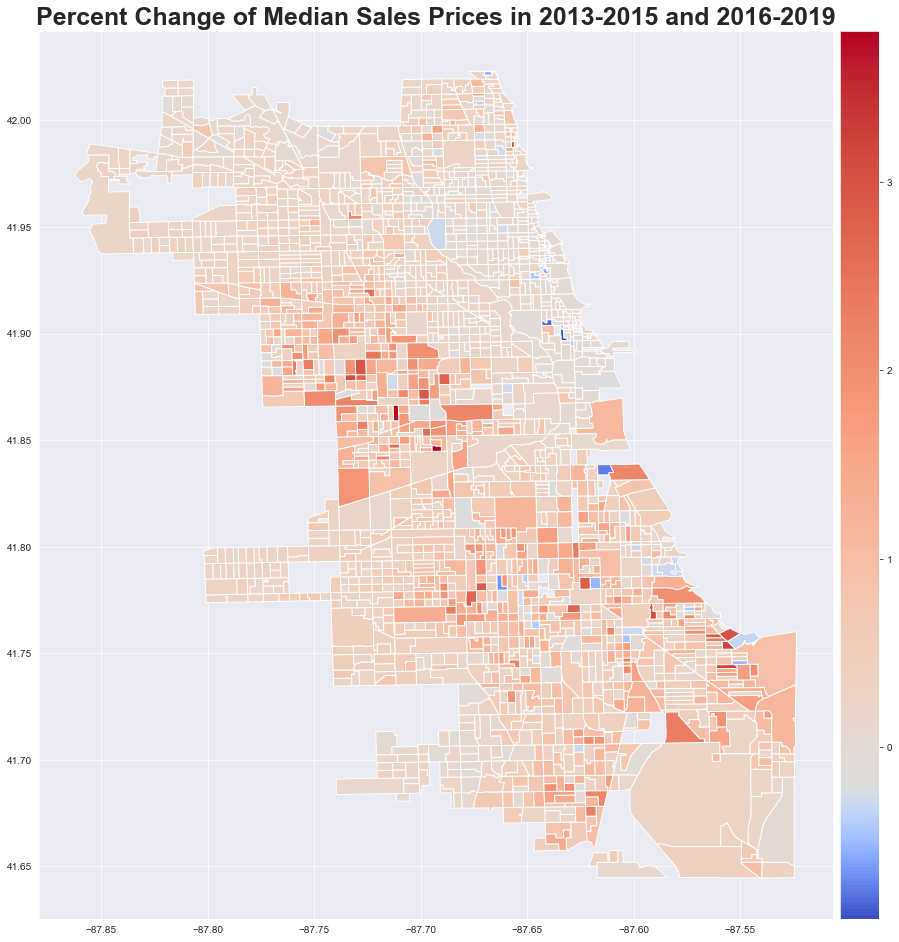

In [18]:
blockgroups = census_gdf.dissolve(by='geo_12').reset_index()
blockgroups.crs = "EPSG:4326"
merged_gdf = sales_compare[['geo_12', 'sales_price_diff']]\
    .merge(blockgroups[['geo_12', 'geometry']], on='geo_12', how="left")
merged_gdf = gpd.GeoDataFrame(merged_gdf.drop_duplicates()).sort_values(by='sales_price_diff')
print(merged_gdf.iloc[:,:2].head())

fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

norm = colors.TwoSlopeNorm (vmin=merged_gdf.sales_price_diff.min(),
                            vcenter=-0.2,
                            vmax=merged_gdf.sales_price_diff.max())
ax = merged_gdf.plot(column='sales_price_diff', legend=True, cmap='coolwarm',
                     ax=ax, cax=cax, norm=norm)
ax.set_title('Percent Change of Median Sales Prices in 2013-2015 and 2016-2019',
             fontsize=25, fontweight="bold", loc='center', y=2.12)

fig.tight_layout()
plt.savefig('figures/censusblock_saleprice_change_heatmap.png')
plt.show()

        pri_neigh  sales_price_diff
64       Old Town         -0.066361
50           Loop         -0.033756
78  Streeterville         -0.022544
44      Lake View          0.001512
33     Gold Coast          0.014450


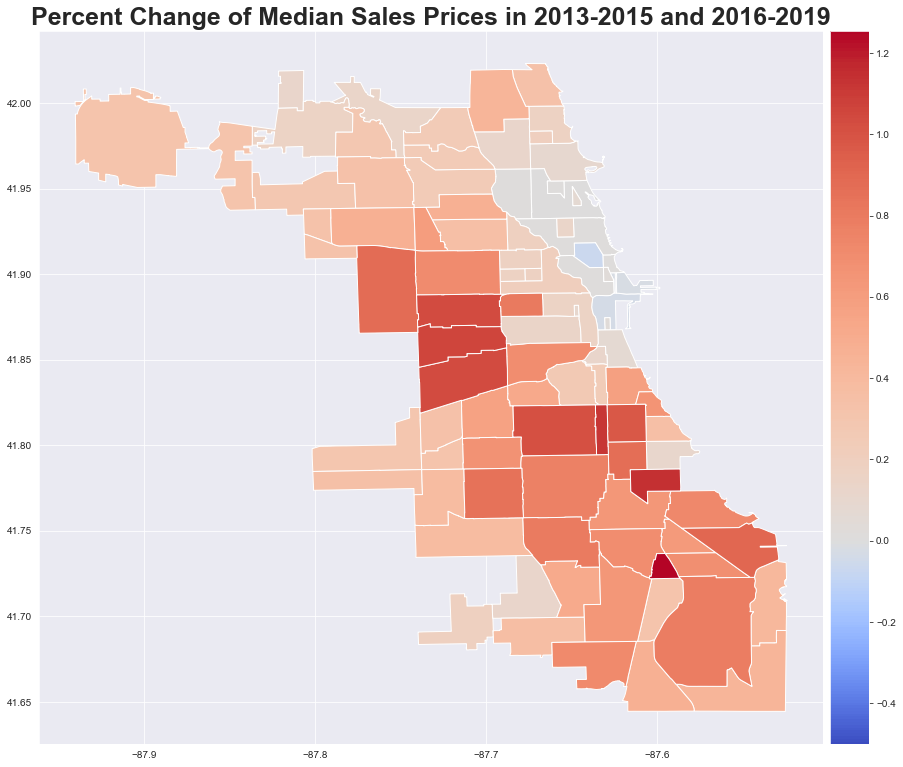

In [19]:
sales_compare = final_df.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
sales_compare['2013-2015'] = sales_compare[[2013, 2014, 2015]].mean(axis=1)
sales_compare['2016-2019'] = sales_compare[[2016, 2017, 2018, 2019]].mean(axis=1)
sales_compare['sales_price_diff'] = (sales_compare['2016-2019'] - sales_compare['2013-2015'])  / sales_compare['2013-2015']

sales_compare = sales_compare.reset_index()
sales_compare = sales_compare[['pri_neigh', 'sales_price_diff']]\
    .merge(neighborhood_gdf[['pri_neigh', 'geometry']], on='pri_neigh', how="left")
sales_compare = gpd.GeoDataFrame(sales_compare.drop_duplicates()).sort_values(by='sales_price_diff')
print(sales_compare.iloc[:,:2].head())

fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

norm = colors.TwoSlopeNorm (vmin=-0.5,
                            vcenter=0,
                            vmax=sales_compare.sales_price_diff.max())
ax = sales_compare.plot(column='sales_price_diff', legend=True, cmap='coolwarm', ax=ax, cax=cax, norm=norm)
ax.set_title('Percent Change of Median Sales Prices in 2013-2015 and 2016-2019', fontsize=25,
             fontweight="bold", loc='center', y=2.12)

fig.tight_layout()
plt.savefig('figures/saleprice_change_heatmap.png')
plt.show()

          pri_neigh  price_income_diff
92     Printers Row          -0.300500
90  Near South Side          -0.181503
82     North Center          -0.164953
83      River North          -0.148524
84        Greektown          -0.142458


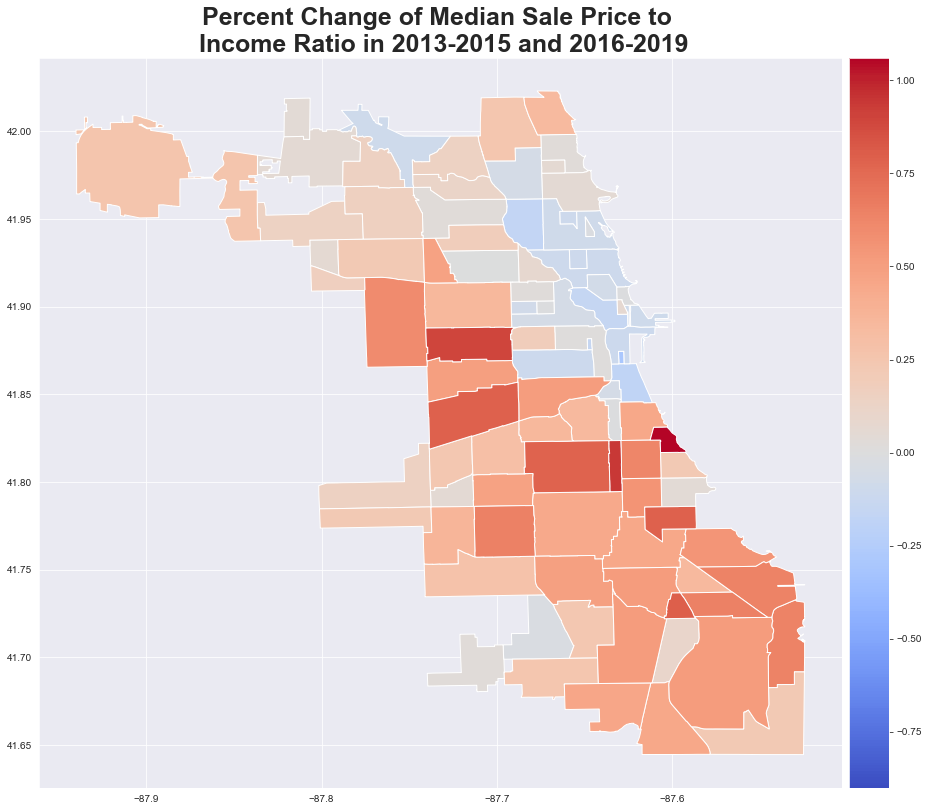

In [20]:
median_income_by_year = final_df.groupby(['pri_neigh', 'Year'])['Median HH Income'].median().unstack()
median_price_by_year = final_df.groupby(['pri_neigh', 'Year'])['sale_price'].median().unstack()
median_inc_to_price = pd.DataFrame()
for year in range(2013, 2019):
    median_inc_to_price[year] = median_price_by_year[year] / median_income_by_year[year]
median_inc_to_price = median_inc_to_price.reset_index()#.sort_values(by=2018, ascending=False)
median_inc_to_price['biggest_diff'] = (median_inc_to_price[2018] - median_inc_to_price[2013]) / median_inc_to_price[2013]
median_inc_to_price = median_inc_to_price.sort_values(by='biggest_diff', ascending=False)
median_inc_to_price = median_inc_to_price[['pri_neigh', 2013, 2014, 2015, 2016, 2017, 2018]]

median_inc_to_price['2013-2015'] = median_inc_to_price[[2013, 2014, 2015]].mean(axis=1)
median_inc_to_price['2016-2018'] = median_inc_to_price[[2016, 2017, 2018]].mean(axis=1)
median_inc_to_price['price_income_diff'] = (median_inc_to_price['2016-2018'] - median_inc_to_price['2013-2015'])\
    / median_inc_to_price['2013-2015']
median_inc_to_price = median_inc_to_price[['pri_neigh', 'price_income_diff']]\
    .merge(neighborhood_gdf[['pri_neigh', 'geometry']], on='pri_neigh', how="left")
median_inc_to_price = gpd.GeoDataFrame(median_inc_to_price.drop_duplicates()).sort_values(by='price_income_diff')
print(median_inc_to_price.iloc[:, :2].head())

fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

norm = colors.TwoSlopeNorm (vmin=-0.9,
                            vcenter=0,
                            vmax=median_inc_to_price.price_income_diff.max())
ax = median_inc_to_price.plot(column='price_income_diff', legend=True, cmap='coolwarm', ax=ax, cax=cax, norm=norm)
ax.set_title('Percent Change of Median Sale Price to \n Income Ratio in 2013-2015 and 2016-2019', fontsize=25,
             fontweight="bold", loc='center', y=2.12)

fig.tight_layout()
plt.savefig('figures/saleprice_income_ratio_change_heatmap.png')
plt.show()

## PREDICTIONS

In [36]:
df_20_21 = pd.read_csv('data/2020_2021_predictions.csv')
df_2020 = df_20_21.loc[df_20_21['Year'] == 2020]



df_2021 = df_20_21.loc[df_20_21['Year'] == 2021]
df_2021

Unnamed: 0                 GEO_ID  Year  predicted_price_p_house
1              1  1500000US170310101001  2021            278222.678931
3              3  1500000US170310101002  2021            211273.287766
5              5  1500000US170310101003  2021            267228.114437
7              7  1500000US170310102011  2021            282613.433289
9              9  1500000US170310102012  2021            221563.790953
...          ...                    ...   ...                      ...
4400        4400  1500000US170318439001  2021            192989.742540
4402        4402  1500000US170318439002  2021            245046.684180
4404        4404  1500000US170318439003  2021            133450.854427
4406        4406  1500000US170318439004  2021            136565.792758
4408        4408  1500000US170318439005  2021            137152.774347

[2212 rows x 4 columns]

In [37]:
blockgroups = census_gdf.dissolve(by='geo_12').reset_index()
blockgroups.crs = "EPSG:4326"

df_2019 = pd.read_csv('data/2019_predictions.csv')
df_2019["geo_12"] = df_2019["GEO_ID"].map(lambda x: str(x)[-12:])
df_2019 = df_2019[['Year', 'actual_price_p_house', 'predicted_price_p_house', 'geo_12']]\
    .merge(blockgroups[['geo_12', 'geometry']], on='geo_12', how="left")
df_2019 = gpd.GeoDataFrame(df_2019.drop_duplicates())
df_2019_block = gpd.sjoin(df_2019, neighborhood_gdf, how='inner', op='intersects')
df_2019_neigh = gpd.sjoin(neighborhood_gdf, df_2019, how='inner', op='intersects')

df_20_21 = pd.read_csv('data/2020_2021_predictions.csv')

df_20_21 = pd.read_csv('data/2020_2021_predictions.csv')
df_2020 = df_20_21.loc[df_20_21['Year'] == 2020]
df_2020["geo_12"] = df_2020["GEO_ID"].map(lambda x: str(x)[-12:])
df_2020 = df_2020[['Year', 'predicted_price_p_house', 'geo_12']]\
    .merge(blockgroups[['geo_12', 'geometry']], on='geo_12', how="left")
df_2020 = gpd.GeoDataFrame(df_2020.drop_duplicates())
df_2020_block = gpd.sjoin(df_2020, neighborhood_gdf, how='inner', op='intersects')
df_2020_neigh = gpd.sjoin(neighborhood_gdf, df_2020, how='inner', op='intersects')

df_2021 = df_20_21.loc[df_20_21['Year'] == 2021]
df_2021["geo_12"] = df_2021["GEO_ID"].map(lambda x: str(x)[-12:])
df_2021 = df_2021[['Year', 'predicted_price_p_house', 'geo_12']]\
    .merge(blockgroups[['geo_12', 'geometry']], on='geo_12', how="left")
df_2021 = gpd.GeoDataFrame(df_2021.drop_duplicates())
df_2021_block = gpd.sjoin(df_2021, neighborhood_gdf, how='inner', op='intersects')
df_2021_neigh = gpd.sjoin(neighborhood_gdf, df_2021, how='inner', op='intersects')

C:\Users\ymeri\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\ymeri\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\ymeri\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ymeri\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\ymeri\anaconda3\lib\site-packages\geopandas\tools\sjoin.py

In [182]:
# df_dict = {df_2019_block: ['actual_price_p_house', 'predicted_price_p_house'],
#            df_2019_neigh: ['actual_price_p_house', 'predicted_price_p_house'],
#            df_2020_block: ['predicted_price_p_house'],
#            df_2020_neigh: ['predicted_price_p_house']}

# for df_year in [(df, col) for df, cols in df_dict.items() for col in cols]:
#     for col in ['actual_price_p_house', 'predicted_price_p_house']:
#         fig, ax = plt.subplots(1, 1, figsize=(13,20))
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.1)

#         ax = df_year.plot(column=col, legend=True, cmap='Reds', ax=ax, cax=cax)
#         ax.set_title('{}, {}'.format(df.Year[0], col.split('_')[0]), fontsize=25,
#              fontweight="bold", loc='center', y=2.12)
        
#         fig.tight_layout()
#         plt.savefig('figures/{}_{}_census_block.png'.format(df.Year[0], col.split('_')[0]))
#         plt.show()

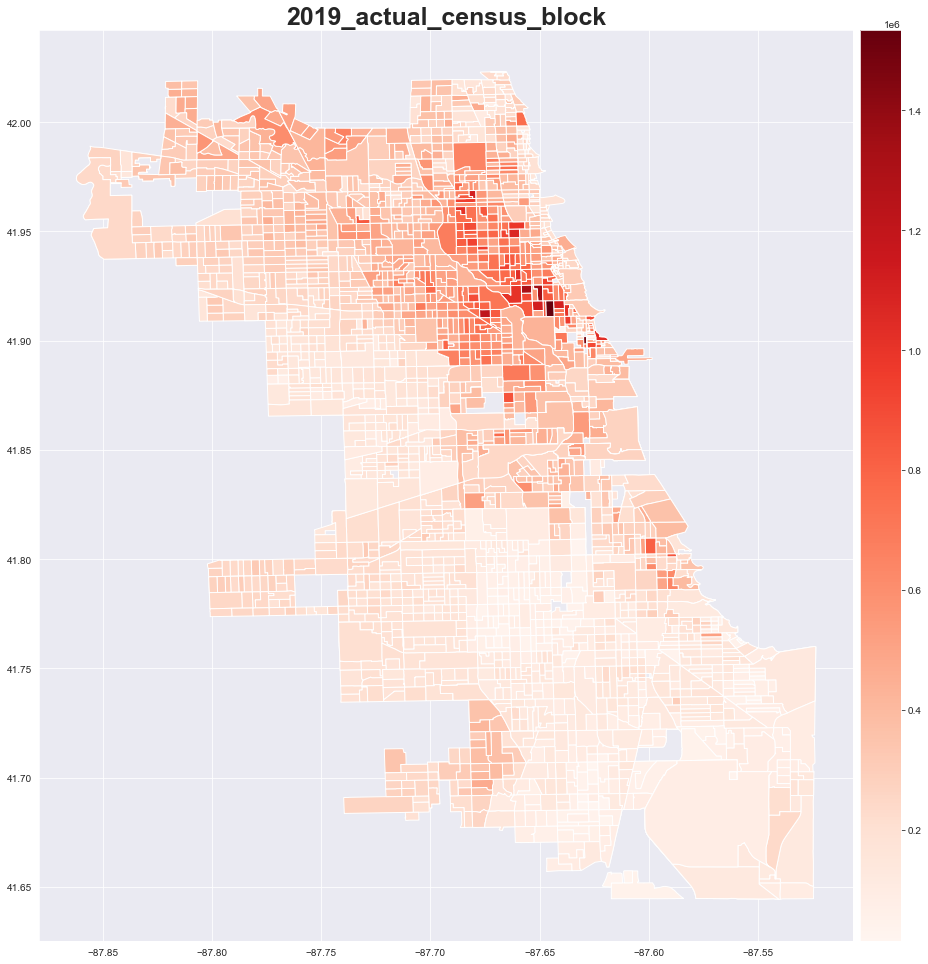

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_actual_census_block'
ax = df_2019_block.plot(column='actual_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2019/{}.png'.format(table_name))
plt.show()

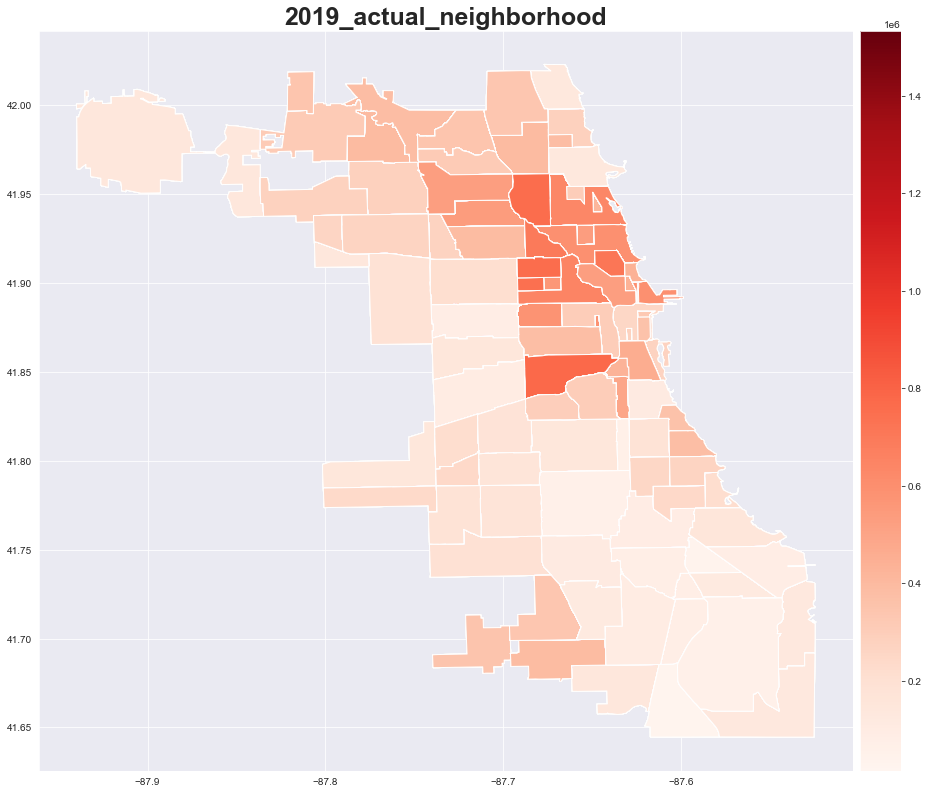

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_actual_neighborhood'
ax = df_2019_neigh.plot(column='actual_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2019/{}.png'.format(table_name))
plt.show()

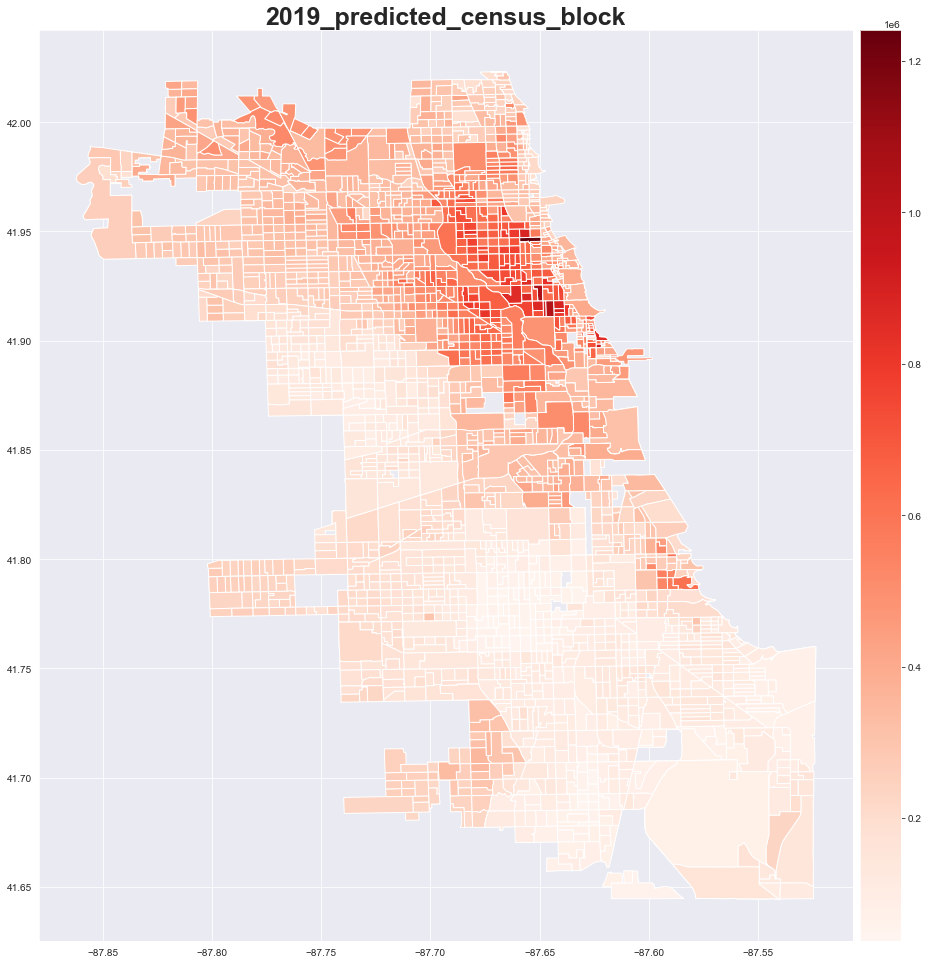

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_predicted_census_block'
ax = df_2019_block.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2019/{}.png'.format(table_name))
plt.show()

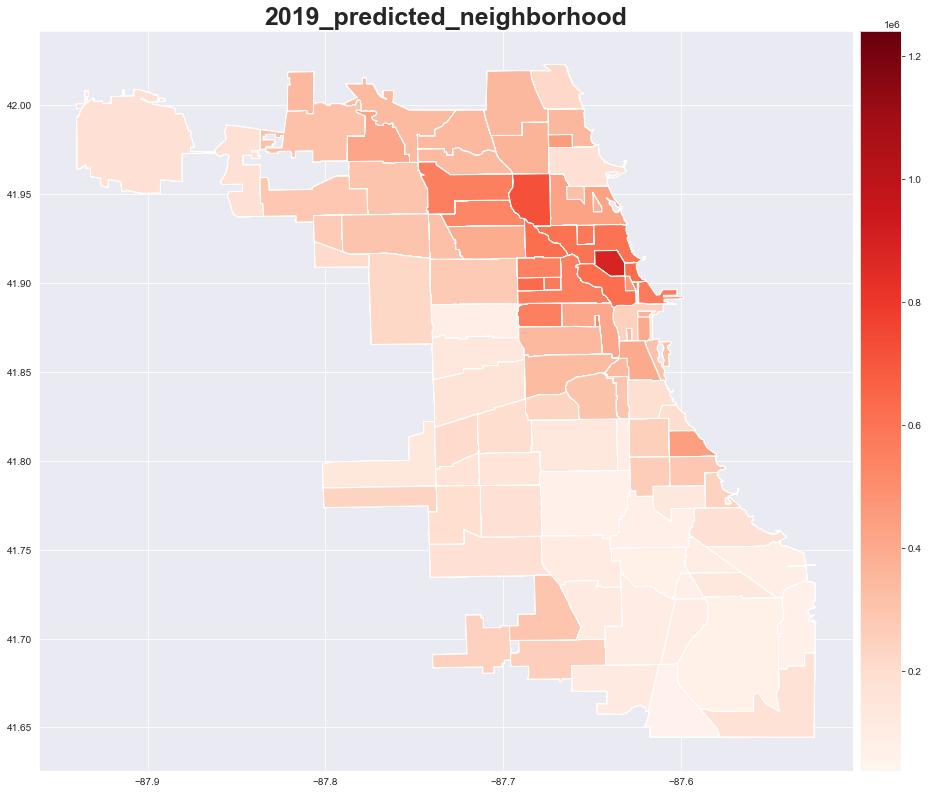

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_predicted_neighborhood'
ax = df_2019_neigh.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2019/{}.png'.format(table_name))
plt.show()

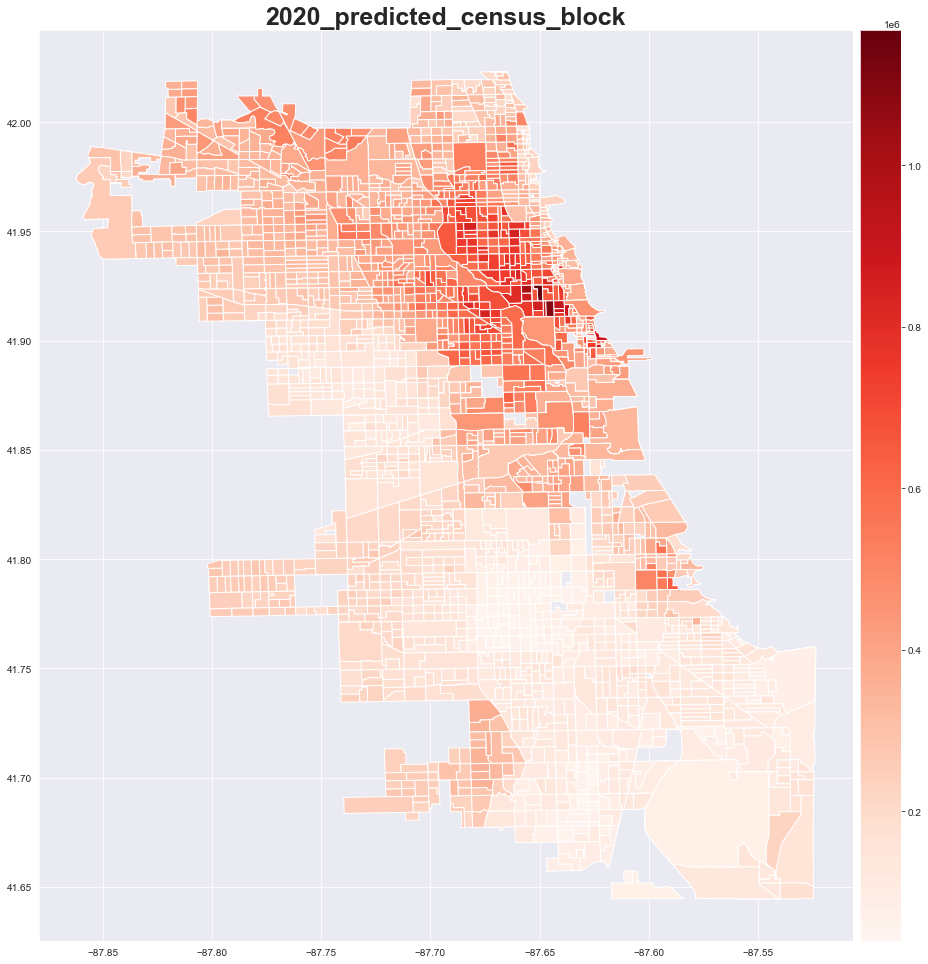

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2020_predicted_census_block'
ax = df_2020_block.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2020_2021/{}.png'.format(table_name))
plt.show()

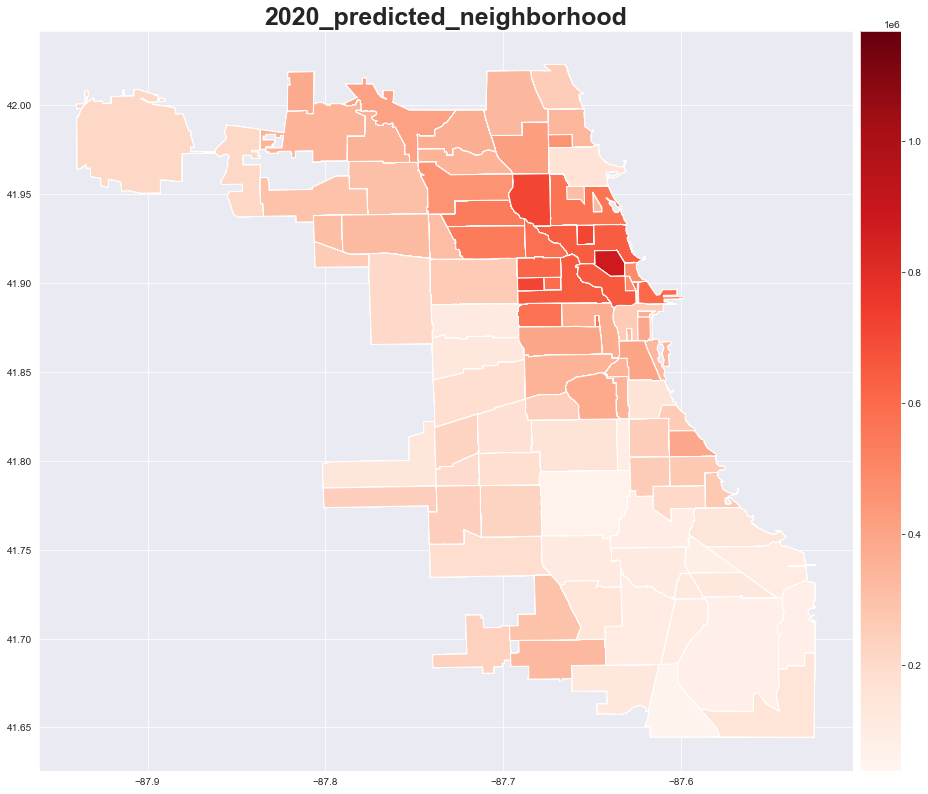

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2020_predicted_neighborhood'
ax = df_2020_neigh.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2020_2021/{}.png'.format(table_name))
plt.show()

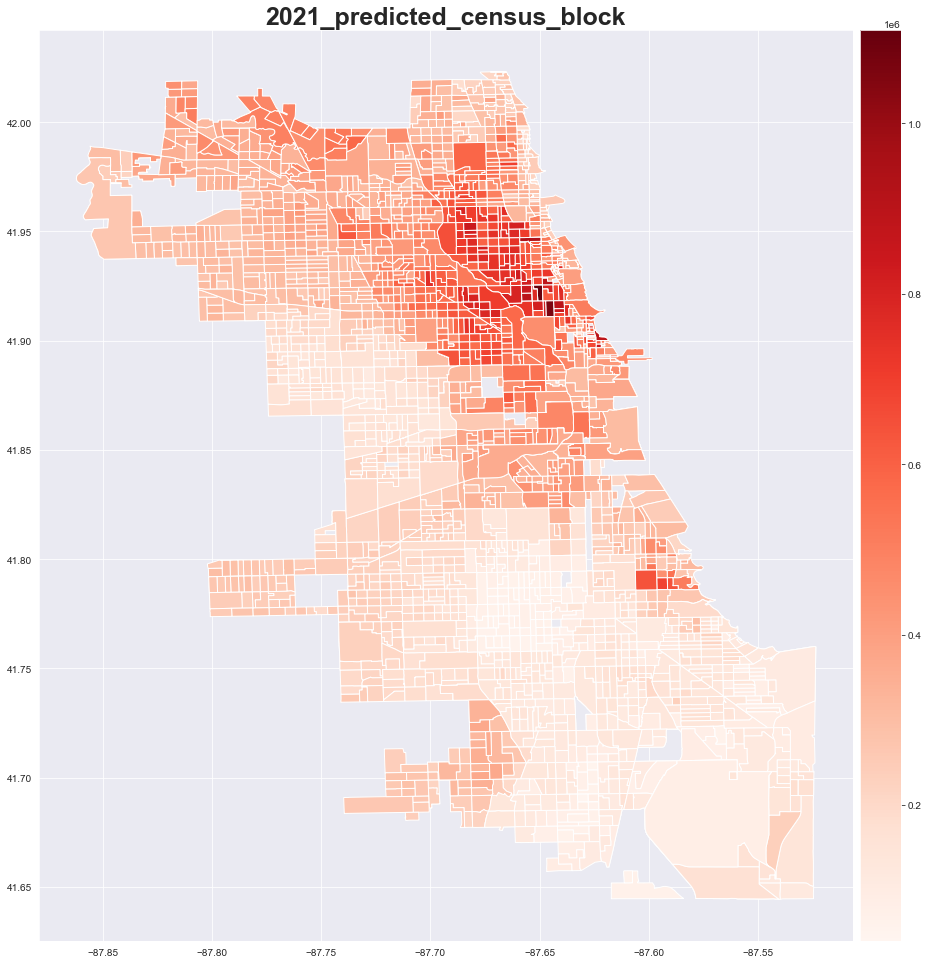

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# norm = colors.TwoSlopeNorm (vmin=-0.1,
#                             vcenter=0,
#                             vmax=1.5)                              
table_name = '2021_predicted_census_block'
ax = df_2021_block.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2020_2021/{}.png'.format(table_name))
plt.show()

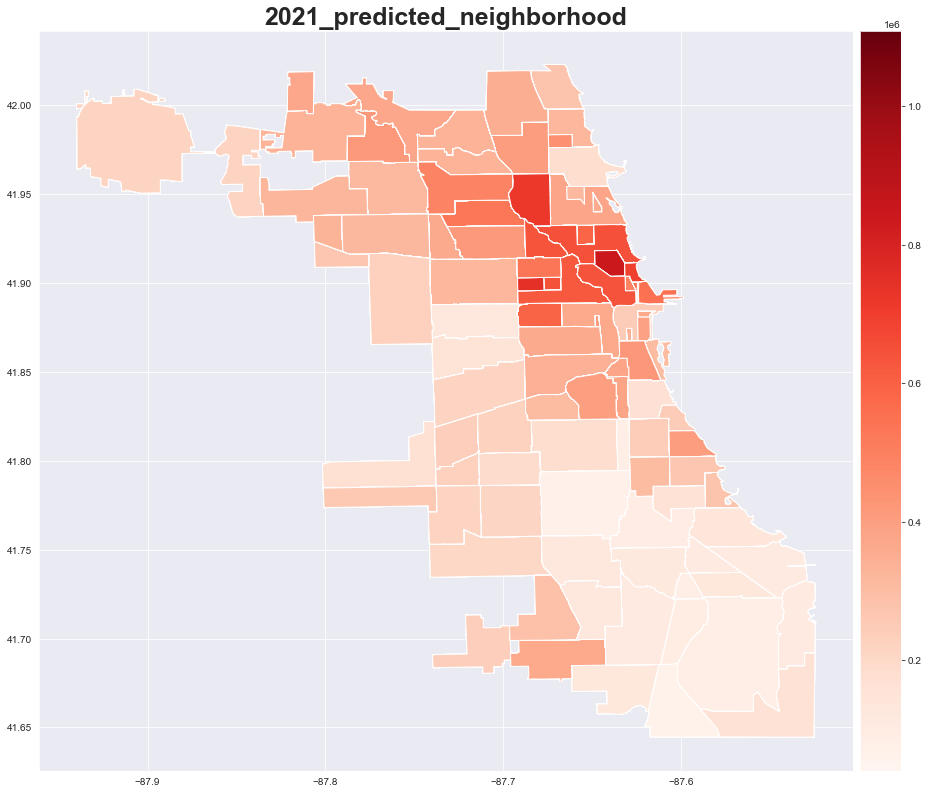

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2021_predicted_neighborhood'
ax = df_2021_neigh.plot(column='predicted_price_p_house', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2020_2021/{}.png'.format(table_name))
plt.show()

In [60]:
price_diff = df_2019_block[['geo_12', 'actual_price_p_house']]\
    .merge(df_2021_block[['geo_12', 'predicted_price_p_house', 'geometry']], on='geo_12', how='inner')
price_diff = price_diff.rename(columns={'actual_price_p_house': '2019_actual_p',
                                                    'predicted_price_p_house': '2021_pred_p'})
price_diff['price_diff_perc'] = (price_diff['2021_pred_p'] - price_diff['2019_actual_p']) / price_diff['2019_actual_p']
price_diff = gpd.GeoDataFrame(price_diff.drop_duplicates())
price_diff.loc[price_diff['price_diff_perc'] > 6, 'price_diff_perc'] = 6
price_diff.sort_values(by='price_diff_perc', ascending=False)

geo_12  2019_actual_p    2021_pred_p  \
2773   170310804002   2.500000e+04  260958.243589   
2811   170310812011   1.300000e+05  966501.705910   
7604   170318400002   6.577610e+04  465555.462049   
8483   170314314004   1.852500e+04  131014.677122   
2812   170310812011   1.300000e+05  866783.689662   
...             ...            ...            ...   
3745   170310811002   7.445000e+05  332647.688410   
6916   170313108002   7.750000e+05  341962.192567   
10062  170316805002   1.555800e+05   64239.828844   
3770   170310812012   9.083400e+05  360255.000911   
2560   170310802021   1.103500e+06  358347.315565   

                                                geometry  price_diff_perc  
2773   POLYGON ((-87.64112 41.90375, -87.64121 41.903...         6.000000  
2811   POLYGON ((-87.62693 41.89916, -87.62719 41.899...         6.000000  
7604   POLYGON ((-87.63862 41.82355, -87.63886 41.823...         6.000000  
8483   POLYGON ((-87.55664 41.76238, -87.55645 41.762...         6.000000  
2812   POLYGON ((-87.62693 41.89916, -87.62719 41.899...         5.667567  
...                                                  ...              ...  
3745   POLYGON ((-87.62822 41.89752, -87.62822 41.897...        -0.553193  
6916   POLYGON ((-87.66612 41.85689, -87.66612 41.856...        -0.558758  
10062  POLYGON ((-87.65347 41.78690, -87.65371 41.786...        -0.587095  
3770   POLYGON ((-87.62820 41.89668, -87.62820 41.896...        -0.603392  
2560   POLYGON ((-87.63285 41.90388, -87.63300 41.903...        -0.675263  

[2297 rows x 5 columns]

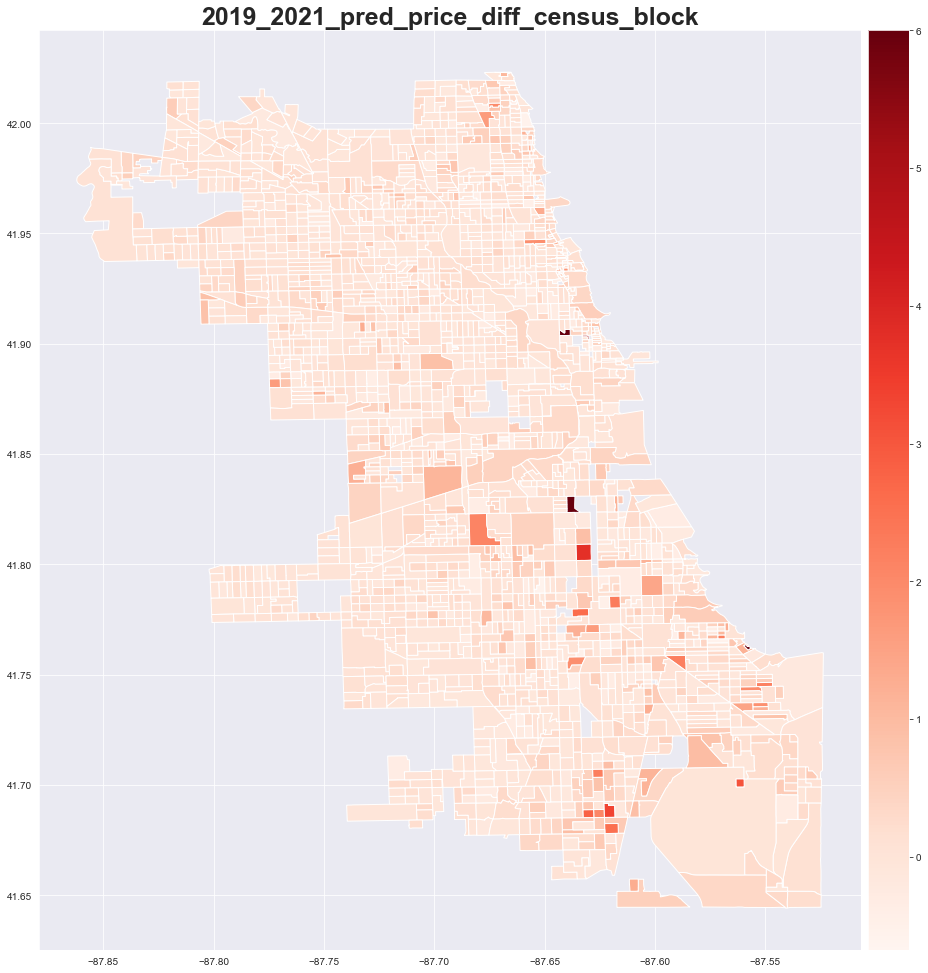

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_2021_pred_price_diff_census_block'
ax = price_diff.plot(column='price_diff_perc', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/{}.png'.format(table_name))
plt.show()

In [61]:
actual_p_neigh = pd.DataFrame(df_2019_neigh.groupby('pri_neigh')['actual_price_p_house'].mean()).reset_index()
predicted_p_neigh = pd.DataFrame(df_2021_neigh.groupby('pri_neigh')['predicted_price_p_house'].mean()).reset_index()
neigh_p_diff = actual_p_neigh.merge(predicted_p_neigh)
neigh_p_diff['p_diff'] = (neigh_p_diff['predicted_price_p_house'] - neigh_p_diff['actual_price_p_house'])\
    / neigh_p_diff['actual_price_p_house']
neigh_p_diff = neigh_p_diff[['pri_neigh', 'p_diff']].merge(df_2021_neigh[['pri_neigh', 'geometry']])
neigh_p_diff = gpd.GeoDataFrame(neigh_p_diff.drop_duplicates())
neigh_p_diff.sort_values(by='p_diff', ascending=False)

pri_neigh    p_diff  \
1120         Fuller Park  0.538875   
2843           Riverdale  0.513056   
500             Boystown  0.310065   
1279          Gold Coast  0.255307   
2783             Pullman  0.251163   
...                  ...       ...   
2639             Oakland -0.032194   
1858        Lincoln Park -0.033014   
790            Chinatown -0.057517   
3026  Sheffield & DePaul -0.111765   
1728             Kenwood -0.127178   

                                               geometry  
1120  MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...  
2843  MULTIPOLYGON (((-87.60157 41.68621, -87.60158 ...  
500   MULTIPOLYGON (((-87.64878 41.93999, -87.64927 ...  
1279  MULTIPOLYGON (((-87.62646 41.91147, -87.62640 ...  
2783  MULTIPOLYGON (((-87.60157 41.68621, -87.60168 ...  
...                                                 ...  
2639  MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...  
1858  MULTIPOLYGON (((-87.62640 41.91137, -87.62646 ...  
790   MULTIPOLYGON (((-87.63022 41.85770, -87.63022 ...  
3026  MULTIPOLYGON (((-87.65833 41.92166, -87.65835 ...  
1728  MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...  

[98 rows x 3 columns]

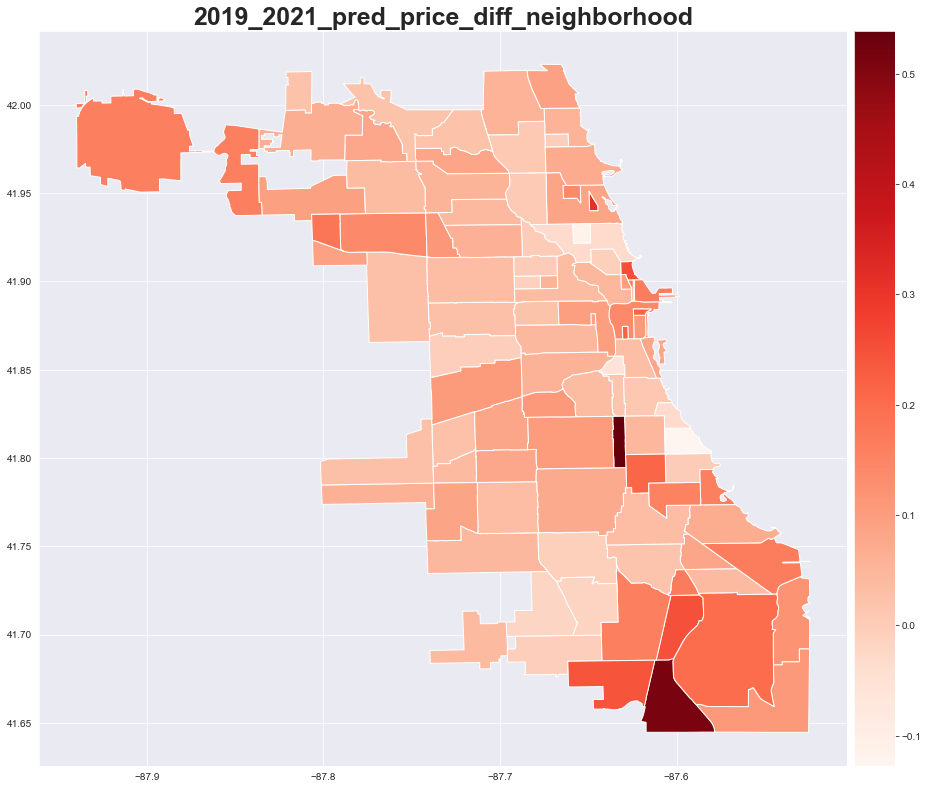

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2019_2021_pred_price_diff_neighborhood'
ax = neigh_p_diff.plot(column='p_diff', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/{}.png'.format(table_name))
plt.show()

## predicted price to income ratio

In [139]:
price_to_income_block.isnull().sum().sort_values(ascending = False)

price_to_income            99
2018                       99
geometry                    0
predicted_price_p_house     0
geo_12                      0
dtype: int64

In [149]:
price_by_block = pd.DataFrame(df_2021_block.groupby('geo_12')['predicted_price_p_house'].mean().reset_index())
price_by_block = price_by_block.merge(df_2021_block[['geo_12', 'geometry']].drop_duplicates())
income_by_block = final_df.groupby(['geo_12', 'Year'])['Median HH Income'].median().unstack().reset_index()\
    [['geo_12', 2018]]
price_to_income_block = income_by_block.merge(price_by_block)
price_to_income_block['price_to_income'] = price_to_income_block['predicted_price_p_house'] / price_to_income_block[2018]
price_to_income_block = gpd.GeoDataFrame(price_to_income_block.drop_duplicates())
price_to_income_block.sort_values(by='price_to_income', ascending=False)

geo_12     2018  predicted_price_p_house  \
2069  170318411004  14288.0            468416.784542   
1077  170313511001  10077.0            302994.715768   
20    170310105031  17227.0            466117.693154   
228   170310605001  34130.0            805670.320152   
1074  170313406001  12713.0            298524.377995   
...            ...      ...                      ...   
1978  170318356001      NaN            128787.630721   
2018  170318382002      NaN            488402.657520   
2025  170318387004      NaN            143112.187702   
2091  170318421003      NaN            226954.742976   
2130  170318439002      NaN            245046.684180   

                                               geometry  price_to_income  
2069  POLYGON ((-87.63004 41.84718, -87.63011 41.847...        32.783929  
1077  POLYGON ((-87.61443 41.82751, -87.61465 41.827...        30.067948  
20    POLYGON ((-87.66061 41.99863, -87.66059 41.998...        27.057392  
228   POLYGON ((-87.66110 41.95102, -87.66145 41.951...        23.605928  
1074  POLYGON ((-87.63324 41.82362, -87.63334 41.823...        23.481820  
...                                                 ...              ...  
1978  POLYGON ((-87.63371 41.80180, -87.63412 41.801...              NaN  
2018  POLYGON ((-87.66641 41.86686, -87.66689 41.866...              NaN  
2025  POLYGON ((-87.71643 41.85896, -87.71667 41.858...              NaN  
2091  POLYGON ((-87.72979 41.89576, -87.72979 41.895...              NaN  
2130  POLYGON ((-87.58632 41.77426, -87.58632 41.774...              NaN  

[2134 rows x 5 columns]

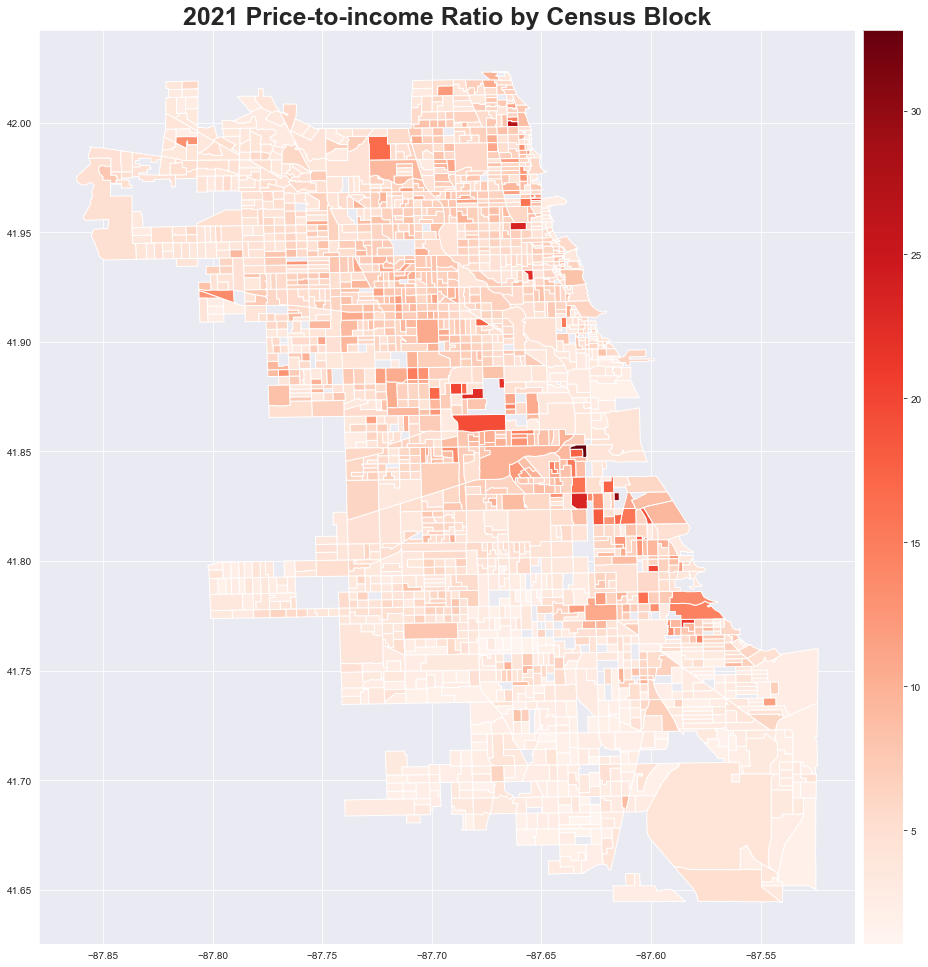

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2021 Price-to-income Ratio by Census Block'
ax = price_to_income_block.plot(column='price_to_income', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2021_price_to_income/{}.png'.format(table_name))
plt.show()

In [161]:
price_by_neigh = pd.DataFrame(df_2021_neigh.groupby('pri_neigh')['predicted_price_p_house'].mean().reset_index())
price_by_neigh = price_by_neigh.merge(df_2021_neigh[['pri_neigh', 'geometry']].drop_duplicates())
income_by_neigh = final_df.groupby(['pri_neigh', 'side', 'Year'])['Median HH Income'].median().unstack().reset_index()\
    [['pri_neigh', 'side', 2018]]
price_to_income_neigh = income_by_neigh.merge(price_by_neigh)
price_to_income_neigh['price_to_income'] = price_to_income_neigh['predicted_price_p_house'] / price_to_income_neigh[2018]
price_to_income_neigh = gpd.GeoDataFrame(price_to_income_neigh.drop_duplicates())
price_to_income_neigh.sort_values(by='price_to_income', ascending=False).head(10)

pri_neigh   side     2018  predicted_price_p_house  \
3     Armour Square  South  34303.0            387554.005203   
19        Chinatown  South  42386.0            410604.371566   
63          Oakland  South  30469.0            290000.733906   
80    United Center   West  45771.0            423232.999226   
51  Lower West Side   West  43006.0            387448.393777   
28      Fuller Park  South  24011.0            206206.686494   
39    Humboldt Park   West  41500.0            346761.092846   
12       Bridgeport  South  46397.0            375172.910875   
8          Avondale  North  59745.0            471878.329997   
91         Woodlawn  South  29970.0            227180.637146   

                                             geometry  price_to_income  
3   MULTIPOLYGON (((-87.62920 41.84713, -87.62919 ...        11.297962  
19  MULTIPOLYGON (((-87.63022 41.85770, -87.63022 ...         9.687264  
63  MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...         9.517895  
80  MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ...         9.246750  
51  MULTIPOLYGON (((-87.63516 41.85772, -87.63532 ...         9.009171  
28  MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...         8.588009  
39  MULTIPOLYGON (((-87.74060 41.88782, -87.74060 ...         8.355689  
12  MULTIPOLYGON (((-87.64173 41.84728, -87.64173 ...         8.086146  
8   MULTIPOLYGON (((-87.68799 41.93610, -87.68798 ...         7.898206  
91  MULTIPOLYGON (((-87.58630 41.77334, -87.58664 ...         7.580268

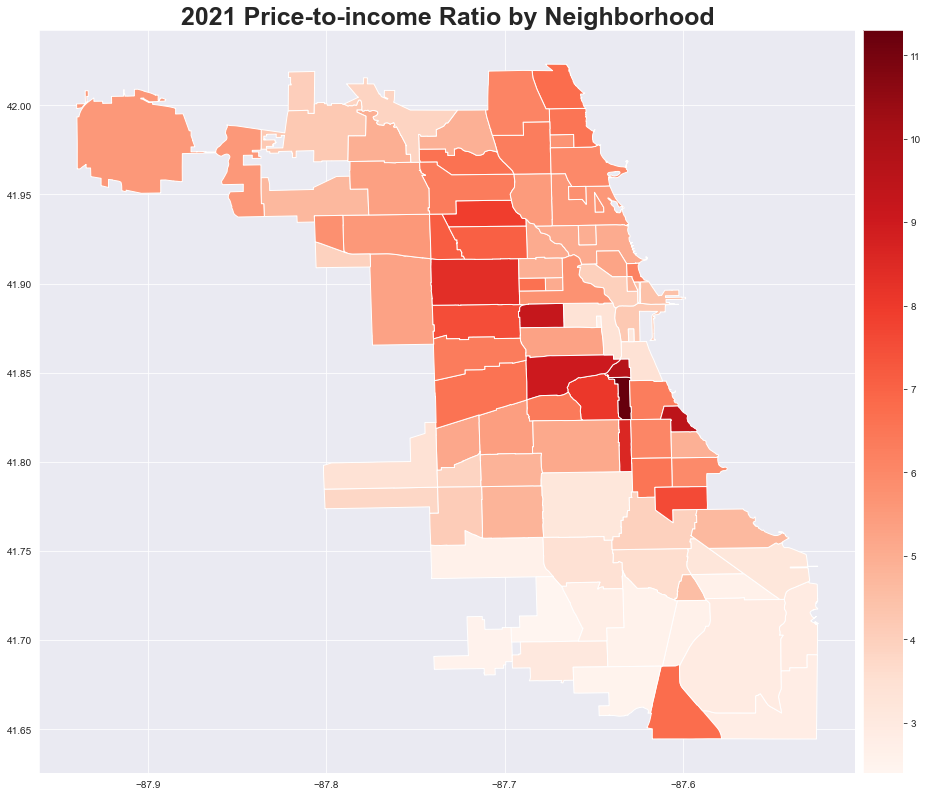

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(13,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

table_name = '2021 Price-to-income Ratio by Neighborhood'
ax = price_to_income_neigh.plot(column='price_to_income', legend=True, cmap='Reds', ax=ax, cax=cax)
ax.set_title(table_name, fontsize=25, fontweight="bold", loc='center', y=2.12)
fig.tight_layout()
plt.savefig('figures/2021_price_to_income/{}.png'.format(table_name))
plt.show()